In [1]:
# import os
# import ast
# from tqdm import tqdm

# all_books_data = ""

# for book in os.listdir("artifacts/book_hi_res"):
#     if book.startswith('Corporate_Finance_Theory_Practice'):
#         continue
#     with open(f"artifacts/book_hi_res/{book}", "r") as f:
#         book_data = ast.literal_eval(f.read())
#     for bd in tqdm(book_data):
#         all_books_data += bd['text']

In [2]:
# with open("all_book_data.txt","w") as f:
#     f.write(all_books_data) 

In [1]:
with open("all_book_data.txt","r") as f:
    all_books_data = f.read() 

In [4]:
# import ast
# from tqdm import tqdm
# with open(f"valuation_mckinsey.txt", "r") as f:
#         book_data = ast.literal_eval(f.read())
# for bd in tqdm(book_data):
#     all_books_data += bd['text']

In [5]:
# with open("all_book_data.txt","w") as f:
#     f.write(all_books_data) 

In [2]:
import json

youtube_transcripts_list = ["chunked_misc_transcripts.json","chunked_transcripts_undergrad.json","chunked_transcripts_mba.json"]    
all_youtube_data = []
for file in youtube_transcripts_list:
    with open('YouTube_API_Transcripts/'+file) as f:
        data = json.load(f)
    for id,data in data.items():
        for d in data:
            all_youtube_data.append(d['text'])

In [7]:
# all_data = all_books_data + all_youtube_data

In [3]:
import re

all_books_data_list = re.split(r"(?<=[.?!])\s+", all_books_data)

## CHUNKING 

In [5]:
!pip install -Uqq langchain

In [61]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    separators = [". "],
    chunk_size=1750,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,

)

books_data_splitted_text = text_splitter.split_text(all_books_data)

In [62]:
num_words = [len(s.split(" ")) for s in books_data_splitted_text]

In [63]:
max(num_words),min(num_words)

(728, 8)

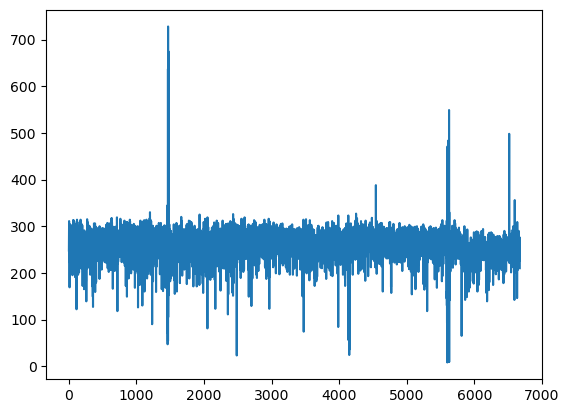

In [64]:
import matplotlib.pyplot as plt

plt.plot(num_words)

In [65]:
sum(num_words)/len(num_words)

262.79892118669466

In [41]:
num_words_yt = [len(s.split(" ")) for s in all_youtube_data]

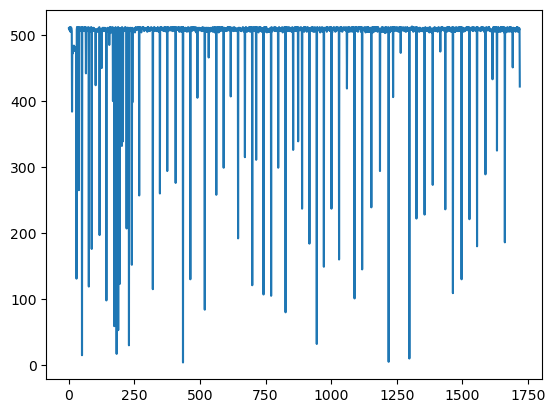

In [42]:
plt.plot(num_words_yt)

In [66]:
all_data = books_data_splitted_text + all_youtube_data

In [69]:
len(books_data_splitted_text),len(all_youtube_data),len(all_data)

(6674, 1720, 8394)

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "distilbert/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [21]:
all_books_data_list[1]

'These stories not only sound persuasive and reasonable but are also backed up by evidence - anecdotal, in some cases, and statistical, in others - that the strategies work.'

In [27]:
all_lens = []

for bd in all_books_data_list:
    ln = len(bd.split(" "))
    all_lens.append(ln)
for yd in all_youtube_data:
    try:
        all_lens.append(len(yd.split(" ")))
    except:
        print(yd)

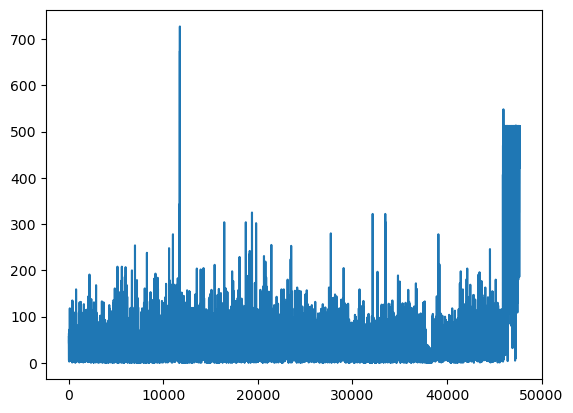

In [28]:
import matplotlib.pyplot as plt
plt.plot(all_lens)

In [31]:
all_data_list = all_books_data_list + all_youtube_data

In [36]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

num_tokens_list = []
for ad in all_data_list:
    try:
        num_tokens_list.append(len(enc.encode(ad)))
    except Exception as e:
        # print(ad)
        print(e)

expected string or buffer


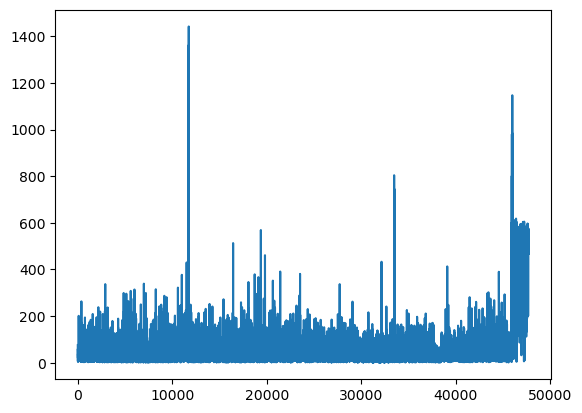

In [38]:
plt.plot(num_tokens_list)